In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn
from tqdm import tqdm

In [10]:
'''
Class used as a template to implement BlackJack
Defination of state - (current sum, dealers showing, ace is usable?)
'''
class BlackJack:
    def __init__(self):
        self.reward_win = 1
        self.reward_loss = -1
        self.reward_draw = 0
        self.cards = [i for i in range(11)]
        self.actions = [1,0]     #0-> stick, 1->hit
        
        self.player_policy = np.ones(22, dtype=int)
        self.player_policy[20] = self.actions[1]
        self.player_policy[21] = self.actions[1]
        
        self.dealer_policy = np.ones(22, dtype=int)
        for i in range(17,22):
            self.dealer_policy[i] = self.actions[1]
    
    def target_player_policy(self, state):
        return self.player_policy[state[0]]
        
    def behaviour_player_policy(self, state):
        pass
    
    def playGame(self, onpolicy = True, random_initial_state = False, random_initial_action = False):
        #generate initial state
        player_sum = 0
        dealer_sum = 0
        
        usable_player_ace = False
        usable_dealer_ace = False
        
        dealer_card1 = -1
        dealer_card2 = -1
        
        #hit till the player_sum is greater than 12
        
        if not random_initial_state:
            while(player_sum < 12):

                #selecting card 1-12 where 1-> Ace, 2-9 normal numbered cards, 10-12 are face cards
                #10-12 group is then brought down to 10 so that they can be used as their value
                card = min(random.randint(1,12), 10)

                if(card == 1):
                    player_sum += 11
                else:
                    player_sum += card

                if(player_sum > 21):
                    #there are two aces taking one as 1
                    if(player_sum == 22):
                        player_sum-=10
                else:
                    usable_player_ace = (card == 1)

            #dealer will show card1
            dealer_card1 = min(random.randint(1,12), 10)
            dealer_card2 = min(random.randint(1,12), 10)
        else:
            player_sum = random.randint(12,21)
            dealer_card1 = random.randint(1,10)
            usable_player_ace = bool(random.randint(0,1))
            dealer_card2 = min(random.randint(1,12), 10)
        
        #calculate the sum of cards for the dealer
        if(dealer_card1 == 1):
            dealer_sum += 11
        else:
            dealer_sum += dealer_card1
            
        if(dealer_card2 == 1):
            dealer_sum += 11
        else:
            dealer_sum += dealer_card2
            
        usable_dealer_ace = (dealer_card1 == 1 or dealer_card2 == 1)
        
        #create the state
        state = (player_sum, dealer_card1, usable_player_ace)
        
        if(dealer_sum > 21):
            #there are two aces taking one as 1
            if(dealer_sum == 22):
                dealer_sum-=10
        
        #Printing values for debuggung (remove them)
#         print("Sums generated for Initial state: ")
#         print(player_sum)
#         print(dealer_sum)
        
        player_history = []
        
        #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        #Player's turn
        while(True):
            if(random_initial_action):
                action = np.random.choice(self.actions)
                random_initial_action = False
            else:
                action = self.player_policy[player_sum]
            
            player_history.append([state, action])
            
            #action to stick to the current state
            if(action == self.actions[1]):
                break
            
            #it has to be a hit now
            card = min(random.randint(1,12), 10)
            
            #counting the number of aces the player has
            player_ace_count = int(state[2])
            
            if(card == 1):
                player_ace_count += 1
                player_sum += 11
            else:
                player_sum += card
                
            while(player_sum > 21 and player_ace_count != 0):
                player_sum -= 10
                player_ace_count -= 1
            
            #player busts
            if(player_sum > 21):
                return state, -1, player_history
            usable_player_ace = (player_ace_count == 1)
            
        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        #Dealer's turn
        while(True):
            action = self.dealer_policy[dealer_sum]
            
            if(action == self.actions[1]):
                break
                
            d_card = min(random.randint(1,12), 10)
            dealer_ace_count = int(usable_dealer_ace)
            
            if(d_card == 1):
                dealer_ace_count += 1
                dealer_sum += 11
            else:
                dealer_sum += d_card
                
            while(dealer_sum > 21 and dealer_ace_count != 0):
                dealer_sum -= 10
                dealer_ace_count -= 1
            
            if(dealer_sum > 21):
                return state, 1, player_history
            usable_dealer_ace = (dealer_ace_count == 1)
            
        if(player_sum > dealer_sum):
            return state, 1, player_history
        elif(player_sum == dealer_sum):
            return state, 0, player_history
        else:
            return state, -1, player_history
        
    def mc_onpolicy(self, episodes):
        self.player_policy = np.ones(22, dtype=int)
        self.player_policy[20] = self.actions[1]
        self.player_policy[21] = self.actions[1]
        
        usable_ace = np.zeros((10,10))
        usable_ace_count = np.ones((10,10))
        
        usable_no_ace = np.zeros((10,10))
        usable_no_ace_count = np.ones((10,10))
        
        for i in range(episodes):
            state, reward, player_history = self.playGame(True)
            for (player_sum, dealer_card1, ace), action in player_history:
                player_sum -= 12
                dealer_card1 -= 1
                if(ace):
                    usable_ace[player_sum, dealer_card1] += reward
                    usable_ace_count[player_sum, dealer_card1] += 1
                else:
                    usable_no_ace[player_sum, dealer_card1] += reward
                    usable_no_ace_count[player_sum, dealer_card1] += 1
                    
        return usable_ace/usable_ace_count, usable_no_ace/usable_no_ace_count
    
    def mc_exploring_starts(self, episodes):
        #make a function for this
        self.player_policy = np.ones(22, dtype=int)
        self.player_policy[20] = self.actions[1]
        self.player_policy[21] = self.actions[1]
        
        #the extra dimension is added for action to get action values
        action_value = np.zeros((10,10,2,2))
        action_value_count = np.ones((10,10,2,2))
        
        for i in range(episodes):
            state, reward, player_history = self.playGame(True, True, True)
            for (player_sum, dealer_card1, ace), action in player_history:
                ace = int(ace)
                player_sum-=12
                dealer_card1-=1
                action_value[player_sum, dealer_card1, ace, action] += reward
                action_value_count[player_sum, dealer_card1, ace, action] += 1
                self.player_policy[player_sum + 12] = np.argmax(action_value[player_sum, dealer_card1, ace, :] / action_value_count[player_sum, dealer_card1, ace, :])
                
#             for player_sum in range(10):
#                 for dealer_card1 in range(10):
#                     for ace in range(2):
#                         self.player_policy[player_sum + 12] = np.argmax(action_value[player_sum, dealer_card1, ace, :] / action_value_count[player_sum, dealer_card1, ace, :])
            
        return action_value / action_value_count
                    
    def mc_offpolicy(self):
        pass
    
    def generatefig51(self):
        usable_ace1, usable_no_ace1 = self.mc_onpolicy(10000)
        usable_ace2, usable_no_ace2 = self.mc_onpolicy(500000)
        
        fig, axes = plt.subplots(2,2,figsize=(20,10))
        
        fig = seaborn.heatmap(usable_ace1[::-1], cmap="YlGnBu", ax=axes[0][0], xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable Ace 10000")
        
        fig = seaborn.heatmap(usable_ace2[::-1], cmap="YlGnBu", ax=axes[0][1], xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable Ace 500000")
        
        fig = seaborn.heatmap(usable_no_ace1[::-1], cmap="YlGnBu", ax=axes[1][0], xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable No Ace 10000")
        
        fig = seaborn.heatmap(usable_no_ace2[::-1], cmap="YlGnBu", ax=axes[1][1], xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable No Ace 500000")    
        
    def generatefig52(self):
        action_values = self.mc_exploring_starts(500000)
        
        usable_ace = np.max(action_values[:,:,0,:], axis=-1)
        usable_no_ace = np.max(action_values[:,:,1,:], axis=-1)
        
        policy_ace = np.argmax(action_values[:,:,0,:], axis=-1)
        policy_no_ace = np.argmax(action_values[:,:,1,:], axis=-1)
        
        fig, axes = plt.subplots(2,2,figsize=(20,10))
        
        fig = seaborn.heatmap(policy_ace[::-1], cmap="YlGnBu",ax=axes[0][0], xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Policy with usable ace")
        
        fig = seaborn.heatmap(usable_ace[::-1], ax=axes[0][1], cmap="YlGnBu", xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Value with usable ace")
        
        fig = seaborn.heatmap(policy_no_ace[::-1], ax=axes[1][0], cmap="YlGnBu", xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Policy with non usable ace")
        
        fig = seaborn.heatmap(usable_no_ace[::-1], ax=axes[1][1], cmap="YlGnBu", xticklabels=range(1,11), yticklabels=range(12,22)[::-1])
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Value with non usable ace")
        
    def generatefig53(self):
        pass

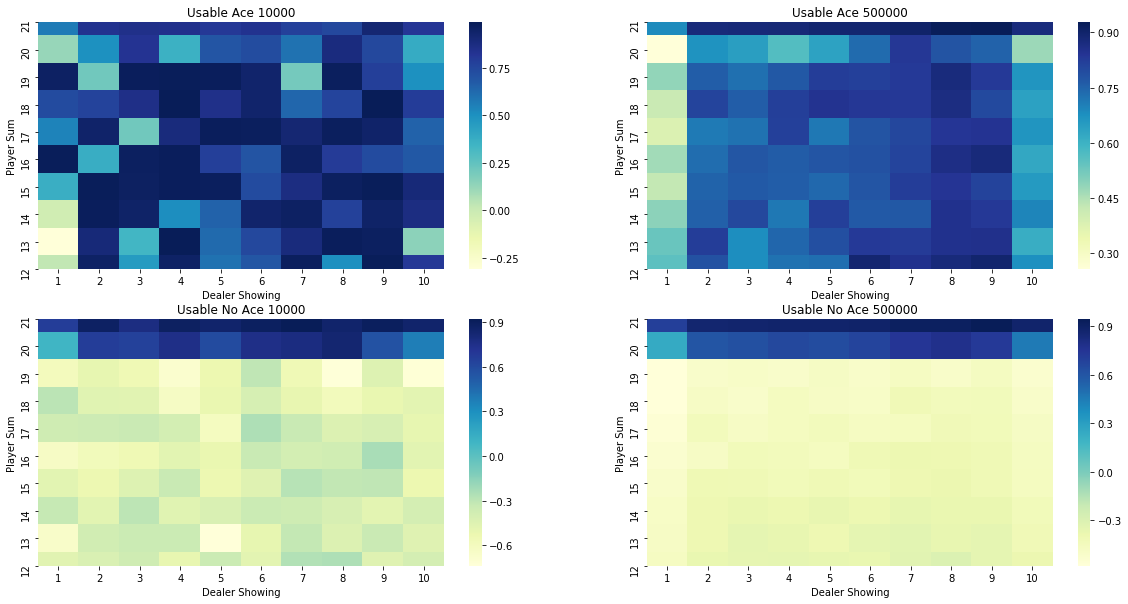

In [11]:
blackjack = BlackJack()
blackjack.generatefig51()

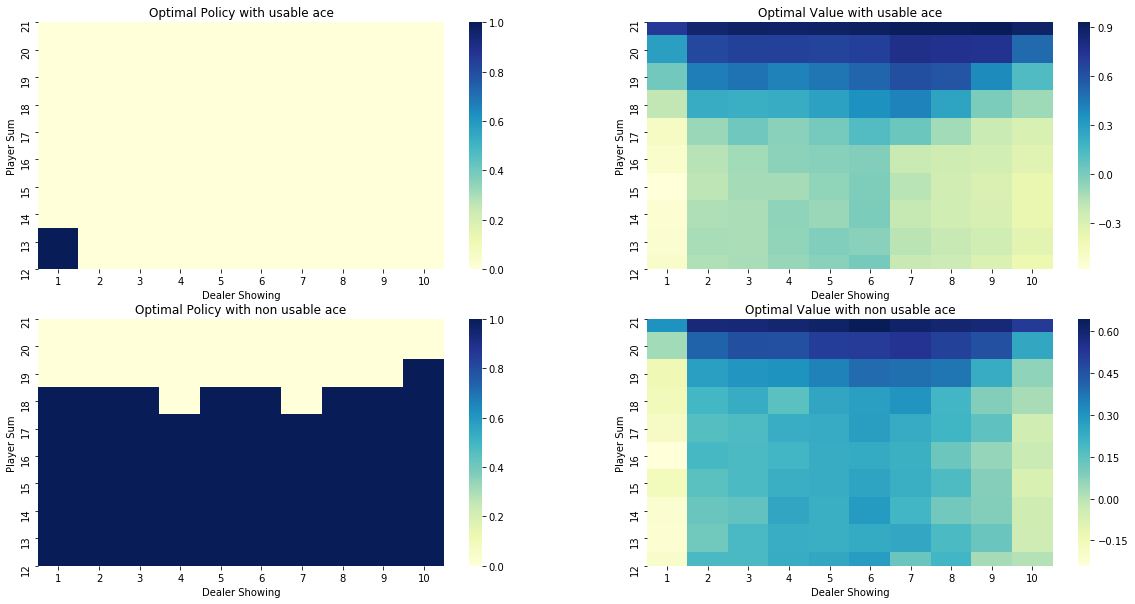

In [12]:
blackjack.generatefig52()